In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

c:\Users\minakshi.mathpal\Anaconda3\envs\pytorch_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available? True


In [4]:
def load_data():
    train_transform = transforms.Compose([
        transforms.RandomRotation((-5.0, 5.0), fill=(1,)),
        transforms.RandomAffine(
            degrees=0,
            translate=(0.05, 0.05),
            scale=(0.98, 1.02)
        ),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_data = datasets.MNIST('data', train=True, download=True, transform=train_transform)
    test_data = datasets.MNIST('data', train=False, transform=test_transform)

    dataloader_args = dict(
        batch_size=128,
        num_workers=4,
        pin_memory=True,
        shuffle=True
    )

    train_loader = DataLoader(train_data, **dataloader_args)
    test_loader = DataLoader(test_data, **dataloader_args)

    return train_loader, test_loader


# Load data
train_loader, test_loader = load_data()

## Data Statistics

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
        transforms.RandomRotation((-5.0, 5.0), fill=(1,)),
        transforms.RandomAffine(
            degrees=0,
            translate=(0.05, 0.05),
            scale=(0.98, 1.02)
        ),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(255.)
 - mean: tensor(33.3184)
 - std: tensor(78.5675)
 - var: tensor(6172.8506)
torch.Size([128, 1, 28, 28])
torch.Size([128])


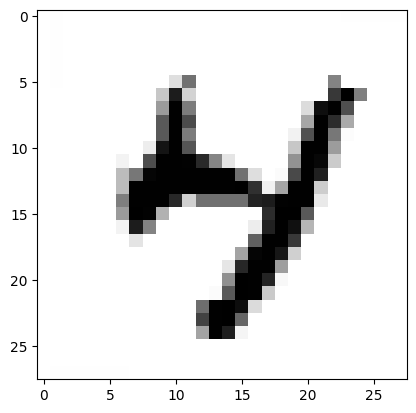

In [5]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)
train_data = train.data.float()  # Convert to float before calculating statistics
train_labels = train.targets  # For MNIST dataset

print('[Train]')
print(' - Numpy Shape:', train.data.cpu().numpy().shape)
print(' - Tensor Shape:', train.data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].squeeze(), cmap='gray_r')  # `.squeeze()` removes singleton dimensions (if any)
plt.show()

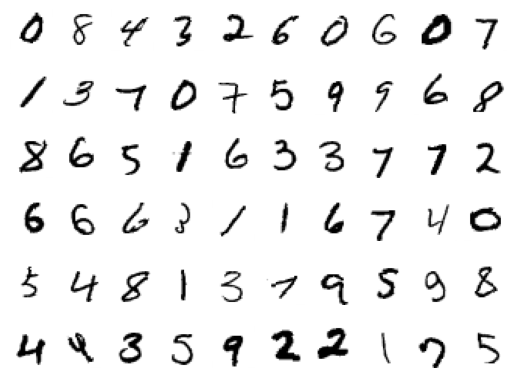

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [18]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer,scheduler):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)
    # Backpropagation
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'LR={optimizer.param_groups[0]["lr"]} Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets


class SimpleMnistModel(nn.Module):
    def __init__(self,dropout_rate=0.01):
        """
        Initialize the model with parameters from config
        Args:
            config: Dictionary containing model configuration
        """
        super().__init__()
        self.dropout_rate=dropout_rate
        # Input Block
        self.conv0 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(self.dropout_rate),
        )
        # CONVOLUTION BLOCK 1
        self.conv1= nn.Sequential(
            nn.Conv2d(8, 10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(self.dropout_rate),
        )
        self.conv2= nn.Sequential(
            nn.Conv2d(10, 12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout(self.dropout_rate),
        )

        # CONVOLUTION BLOCK 2
        self.conv3= nn.Sequential(
            nn.Conv2d(12, 15, kernel_size=3, stride=1,padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(15),
            nn.Dropout(self.dropout_rate)
        )
        self.pool1=nn.MaxPool2d(kernel_size=2, stride=2)

         # CONVOLUTION BLOCK 2
        self.conv4= nn.Sequential(
            nn.Conv2d(15, 15, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(15),
            nn.Dropout(self.dropout_rate),
        )

        self.pool2=nn.Sequential(nn.MaxPool2d(kernel_size=2, stride=2))

        self.gap=nn.Sequential(
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc= nn.Conv2d(15, 10, kernel_size=1, stride=1)

    def forward(self, x):
        x= self.conv0(x)
        x= self.conv1(x)
        x= self.pool1(x)
        x= self.conv2(x)
        x= self.conv3(x)
        x= self.pool2(x)
        x= self.conv4(x)
        x= self.gap(x)
        x= self.fc(x)
        x = x.view(-1, 10)
        return F.log_softmax(x,dim=1)

    def compute_l1_loss(self, w):
        return torch.abs(w).sum()


In [20]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = SimpleMnistModel().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             720
              ReLU-6           [-1, 10, 24, 24]               0
       BatchNorm2d-7           [-1, 10, 24, 24]              20
           Dropout-8           [-1, 10, 24, 24]               0
         MaxPool2d-9           [-1, 10, 12, 12]               0
           Conv2d-10           [-1, 12, 10, 10]           1,080
             ReLU-11           [-1, 12, 10, 10]               0
      BatchNorm2d-12           [-1, 12, 10, 10]              24
          Dropout-13           [-1, 12, 10, 10]               0
           Conv2d-14           [-1

In [32]:
from io import StringIO
import sys

# Redirect stdout to a buffer
original_stdout = sys.stdout
summary_buffer = StringIO()
sys.stdout = summary_buffer

# Generate the summary
summary(model, input_size=(1, 28, 28))

# Restore stdout and write summary to a file
sys.stdout = original_stdout
with open('model_3_summary.txt', 'w') as f:
    f.write(summary_buffer.getvalue())

In [7]:
from torch.optim.lr_scheduler import StepLR
EPOCHS = 15
model =  SimpleMnistModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.003, weight_decay=5e-5)
scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=0.003,
        epochs=EPOCHS,
        steps_per_epoch=len(train_loader),
        pct_start=0.2,
        anneal_strategy='cos',
        div_factor=25.0,
        final_div_factor=1000.0
    )
sch_dict = scheduler.state_dict()
sch_dict['total_steps'] = sch_dict['total_steps'] + EPOCHS * int(len(train_loader))
scheduler.load_state_dict(sch_dict)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, scheduler)
    test(model, device, test_loader)

EPOCH: 0


LR=0.000840929030019079 Loss=0.4353465139865875 Batch_id=468 Accuracy=66.27: 100%|██████████| 469/469 [00:06<00:00, 70.18it/s]  



Test set: Average loss: 0.3768, Accuracy: 9529/10000 (95.29%)

EPOCH: 1


LR=0.002281856861292636 Loss=0.09197524935007095 Batch_id=468 Accuracy=96.11: 100%|██████████| 469/469 [00:06<00:00, 73.18it/s] 



Test set: Average loss: 0.0844, Accuracy: 9806/10000 (98.06%)

EPOCH: 2


LR=0.002999999766312519 Loss=0.03992077335715294 Batch_id=468 Accuracy=97.67: 100%|██████████| 469/469 [00:06<00:00, 75.81it/s]  



Test set: Average loss: 0.0552, Accuracy: 9846/10000 (98.46%)

EPOCH: 3


LR=0.0029486738546826213 Loss=0.04931224510073662 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:06<00:00, 75.19it/s] 



Test set: Average loss: 0.0495, Accuracy: 9856/10000 (98.56%)

EPOCH: 4


LR=0.0027986273028036877 Loss=0.1120648980140686 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:06<00:00, 75.44it/s]  



Test set: Average loss: 0.0329, Accuracy: 9906/10000 (99.06%)

EPOCH: 5


LR=0.002560085535222616 Loss=0.018109245225787163 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:06<00:00, 74.83it/s] 



Test set: Average loss: 0.0297, Accuracy: 9899/10000 (98.99%)

EPOCH: 6


LR=0.002249304779191147 Loss=0.0489172637462616 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:06<00:00, 74.69it/s]   



Test set: Average loss: 0.0314, Accuracy: 9903/10000 (99.03%)

EPOCH: 7


LR=0.001887464229643342 Loss=0.05918693169951439 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:06<00:00, 75.47it/s]   



Test set: Average loss: 0.0251, Accuracy: 9916/10000 (99.16%)

EPOCH: 8


LR=0.0014992227220611033 Loss=0.021669449284672737 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:06<00:00, 74.61it/s] 



Test set: Average loss: 0.0234, Accuracy: 9922/10000 (99.22%)

EPOCH: 9


LR=0.0011110382735867337 Loss=0.012095938436686993 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:06<00:00, 75.88it/s] 



Test set: Average loss: 0.0220, Accuracy: 9935/10000 (99.35%)

EPOCH: 10


LR=0.0007493650128786283 Loss=0.007393062114715576 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:06<00:00, 75.28it/s] 



Test set: Average loss: 0.0210, Accuracy: 9932/10000 (99.32%)

EPOCH: 11


LR=0.000438850374960721 Loss=0.015579749830067158 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:06<00:00, 75.04it/s]  



Test set: Average loss: 0.0169, Accuracy: 9948/10000 (99.48%)

EPOCH: 12


LR=0.0002006554192574164 Loss=0.012115404941141605 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:06<00:00, 74.37it/s]  



Test set: Average loss: 0.0175, Accuracy: 9943/10000 (99.43%)

EPOCH: 13


LR=5.101273836411788e-05 Loss=0.02253730408847332 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:06<00:00, 75.38it/s]   



Test set: Average loss: 0.0171, Accuracy: 9946/10000 (99.46%)

EPOCH: 14


LR=1.2023368748134843e-07 Loss=0.0024191683623939753 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:06<00:00, 73.53it/s]



Test set: Average loss: 0.0171, Accuracy: 9944/10000 (99.44%)

